In [26]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import category_encoders as ce

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 
%matplotlib inline

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [27]:
RANDOM_SEED = 42

In [28]:
!pip freeze > requirements.txt

In [29]:
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [31]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [32]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [33]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [34]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [35]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [39]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_train, df_test], ignore_index = True)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [42]:
# извлекаем признак страны из адреса
# название Англии в датасете именуется как Kingdom, переименуем ее в United Kingdom
# выведем количество стран в датасете

data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1])
data['hotel_country'] = data['hotel_country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
display(data['hotel_country'].value_counts())

hotel_country
United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: count, dtype: int64

In [44]:
# извлекаем признак города из адреса
# выведем количество городов

data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split(' ')[-2])
data['hotel_city'] = data['hotel_city'].apply(lambda x: 'London' if x == 'United' else x)
display(data['hotel_city'].value_counts())

hotel_city
London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: count, dtype: int64

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

В признаках lat и lng имеются пропуски, проработаем их

In [47]:
# устанавливаем библиотеку для множественной импутации пропущенных значений
!pip install fancyimpute

ERROR: Could not find a version that satisfies the requirement fancyimpute (from versions: none)
ERROR: No matching distribution found for fancyimpute


In [52]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [53]:
# Создаем копию датафрейма data для безопасной множественной импутации
# data_imputed = data.copy()

# Заменяем все пропущенные значения в столбце 'lat' на NaN
data['lat'].replace('', np.nan, inplace=True)

# Создаем экземпляр класса IterativeImputer
imputer = IterativeImputer()

# Производим множественную импутацию
data['lat'] = imputer.fit_transform(data['lat'].values.reshape(-1, 1))

# Преобразуем столбец 'lat' обратно к формату DataFrame
data['lat'] = pd.DataFrame(data['lat'], columns=['lat'])

# Проверяем, что в столбце 'lat' больше нет пропущенных значений
print(data['lat'].isnull().sum())

0


In [54]:
# Заменяем все пропущенные значения в столбце 'lng' на NaN
data['lng'].replace('', np.nan, inplace=True)

# Создаем экземпляр класса IterativeImputer
imputer = IterativeImputer()

# Производим множественную импутацию
data['lng'] = imputer.fit_transform(data['lng'].values.reshape(-1, 1))

# Преобразуем столбец 'lng' обратно к формату DataFrame
data['lng'] = pd.DataFrame(data['lng'], columns=['lng'])

# Проверяем, что в столбце 'lng' больше нет пропущенных значений
print(data['lng'].isnull().sum())

0


In [56]:
# проверим количество пропусков
data.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
hotel_country                                 0
hotel_city                                    0
dtype: int64

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [58]:
# кодируем страну отеля
data['hotel_country'] = data['hotel_country'].astype('category')
data['hotel_country_code'] = data['hotel_country'].cat.codes

# кодируем город отеля
data['hotel_city'] = data['hotel_city'].astype('category')
data['hotel_city_code'] = data['hotel_city'].cat.codes

In [59]:
# проверяем, что получилось
data[['hotel_country', 'hotel_country_code', 'hotel_city', 'hotel_city_code']]

,hotel_country,hotel_country_code,hotel_city,hotel_city_code
0,United Kingdom,5,London,2
1,United Kingdom,5,London,2
2,France,1,Paris,4
3,France,1,Paris,4
4,Netherlands,3,Amsterdam,0
...,...,...,...,...
515733,Italy,2,Milan,3
515734,Spain,4,Barcelona,1
515735,Austria,0,Vienna,5
515736,Italy,2,Milan,3


In [68]:
# извлекаем возможные составляющие из даты отзыва
data['review_date'] = pd.to_datetime(data['review_date'])
data['timestamp'] = data['review_date'].apply(lambda x: x.timestamp())
data['month'] = data['review_date'].apply(lambda x: x.month)
data['year'] = data['review_date'].apply(lambda x: x.year)
data['weekday'] = data['review_date'].apply(lambda x: x.weekday())

In [69]:
# применяем бинарное кодирование для признака национальности автора обзора
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

In [70]:
# выделяем дни из поля с информацией, сколько дней прошло с отзыва
data['days_since_review_1'] = data['days_since_review'].apply(lambda x: int(str(x.split()[0])))

In [71]:
# выносим в отдельный признак наличие хотя бы одного слова в положительном и в отрицательном отзывах
data['negative'] = data['review_total_negative_word_counts'].apply(lambda x: 0 if x==0 else 1)
data['positive'] = data['review_total_positive_word_counts'].apply(lambda x: 0 if x==0 else 1)

In [109]:
# Посчитаем число уникальных тегов
res_set = set()
for tags in data['tags']:
    res_set.update(set(tags))
len(res_set)

2428

In [112]:
tag_dict =  dict()
for tags in data['tags']:
    for tag in tags:
        if tag in tag_dict:
            tag_dict[tag] = tag_dict[tag]+1
        else:
            tag_dict[tag] = 1

In [114]:
from collections import OrderedDict

In [116]:
# поиск наболее популярных тегов
ord_dict = OrderedDict(tag_dict)
popular_tags = sorted(ord_dict.items(), key = lambda x:x[1], reverse=True)[:25]
print(popular_tags)

[('Leisure trip', 417778), ('Submitted from a mobile device', 307640), ('Couple', 252294), ('Stayed 1 night', 193645), ('Stayed 2 nights', 133937), ('Solo traveler', 108545), ('Stayed 3 nights', 95821), ('Business trip', 82939), ('Group', 65392), ('Family with young children', 61015), ('Stayed 4 nights', 47817), ('Double Room', 35207), ('Standard Double Room', 32248), ('Superior Double Room', 31393), ('Family with older children', 26349), ('Deluxe Double Room', 24823), ('Double or Twin Room', 22393), ('Stayed 5 nights', 20845), ('Standard Double or Twin Room', 17483), ('Classic Double Room', 16989), ('Superior Double or Twin Room', 13570), ('2 rooms', 12393), ('Stayed 6 nights', 9776), ('Standard Twin Room', 9745), ('Single Room', 9670)]


In [117]:
# создадим новый признак 
data['leisure_trip'] = data['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
data['business_trip'] = data['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)

In [118]:
# посмотрим важен ли способ бронирования
data['from_mobile'] = data['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

In [119]:
# создадим признаки по количеству гостей
data['solo'] = data['tags'].apply(lambda x: 1 if 'Solo traveler' in x else 0)
data['couple'] = data['tags'].apply(lambda x: 1 if 'Couple' in x else 0)
data['group'] = data['tags'].apply(lambda x: 1 if 'Group' in x else 0)
data['with_children'] = data['tags'].apply(lambda x: 1 if ('Family with young children' in x) 
                                                        or ('Family with older children' in x) else 0)

In [120]:
# удалим признак 'tags'
data = data.drop(['tags'], axis=1)

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 55 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [122]:
# убираем нечисловые признаки, 


object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

object_data = [s for s in data.columns if data[s].dtypes == 'datetime64[ns]']
data.drop(object_data, axis = 1, inplace=True)

In [123]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 48 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                515738 non-null  int64   
 1   average_score                               515738 non-null  float64 
 2   review_total_negative_word_counts           515738 non-null  int64   
 3   total_number_of_reviews                     515738 non-null  int64   
 4   review_total_positive_word_counts           515738 non-null  int64   
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64   
 6   reviewer_score                              515738 non-null  float64 
 7   lat                                         515738 non-null  float64 
 8   lng                                         515738 non-null  float64 
 9   sample                                      515738 non-null

In [124]:
data.drop('hotel_city', axis = 1 ,inplace = True)

In [125]:
data.drop('hotel_country', axis = 1 ,inplace = True)

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 46 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   reviewer_score                              515738 non-null  float64
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

<Axes: >

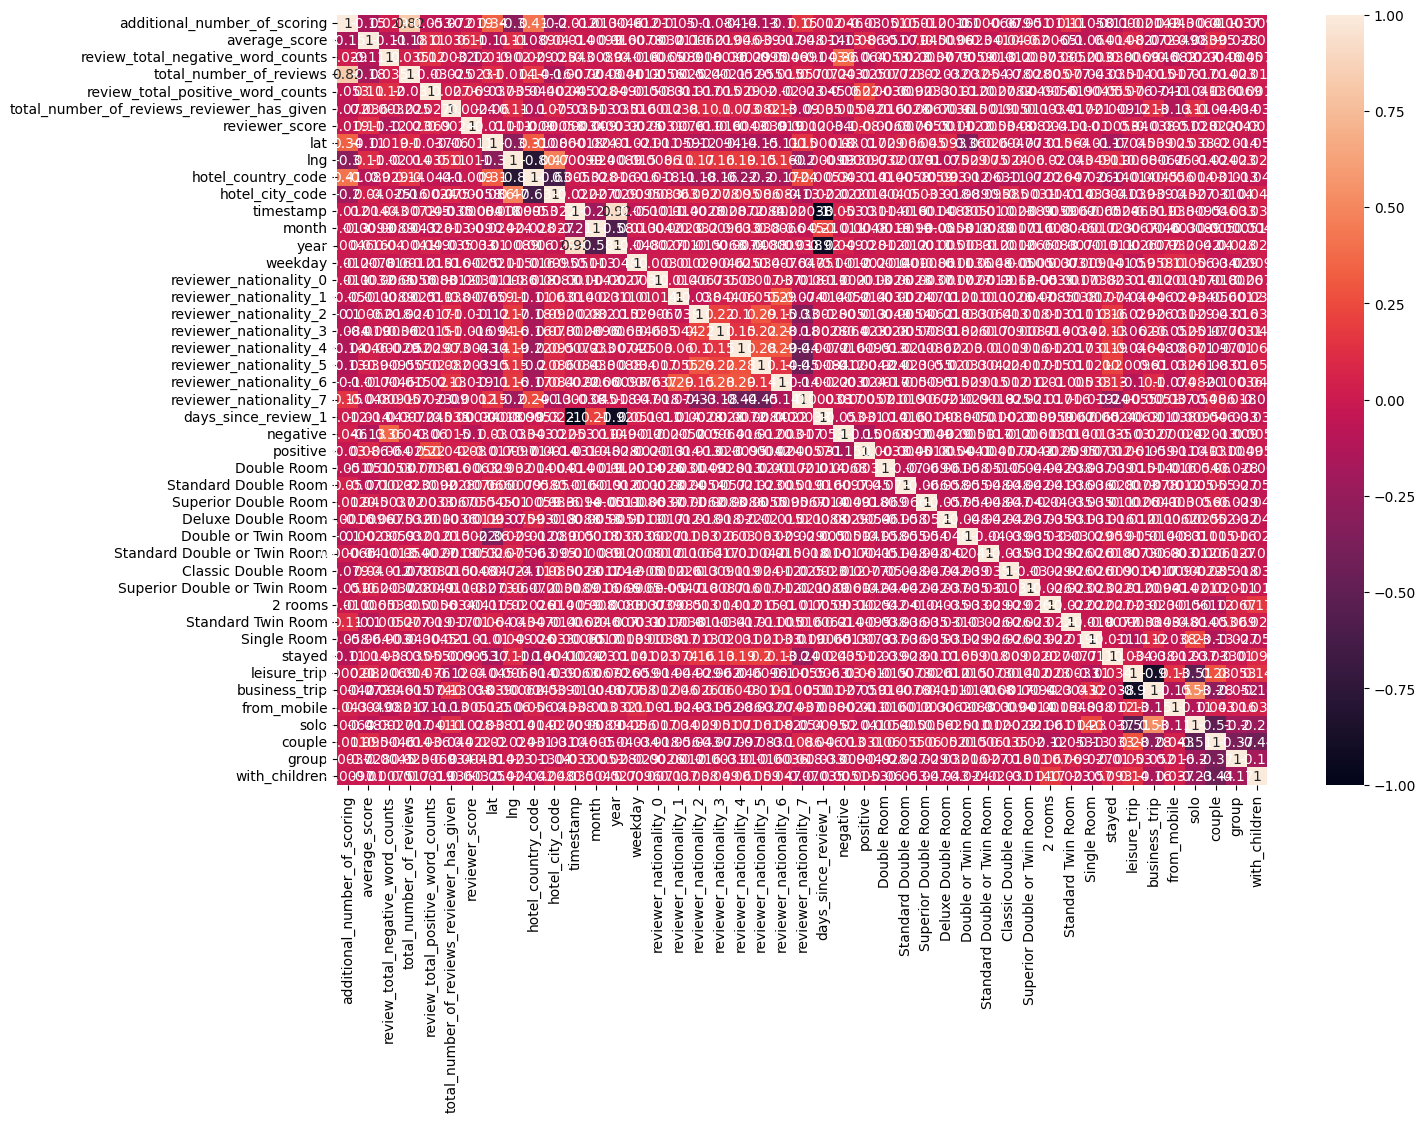

In [127]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [142]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [143]:
# Воспользуемся специальной функцие train_test_split для разбивки тренировочных данных
# выделим 20% данных на валидацию (параметр test_size)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [144]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 45), (386803, 45), (386803, 44), (309442, 44), (77361, 44))

In [145]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [146]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [147]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [148]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9404286162709027


<Axes: >

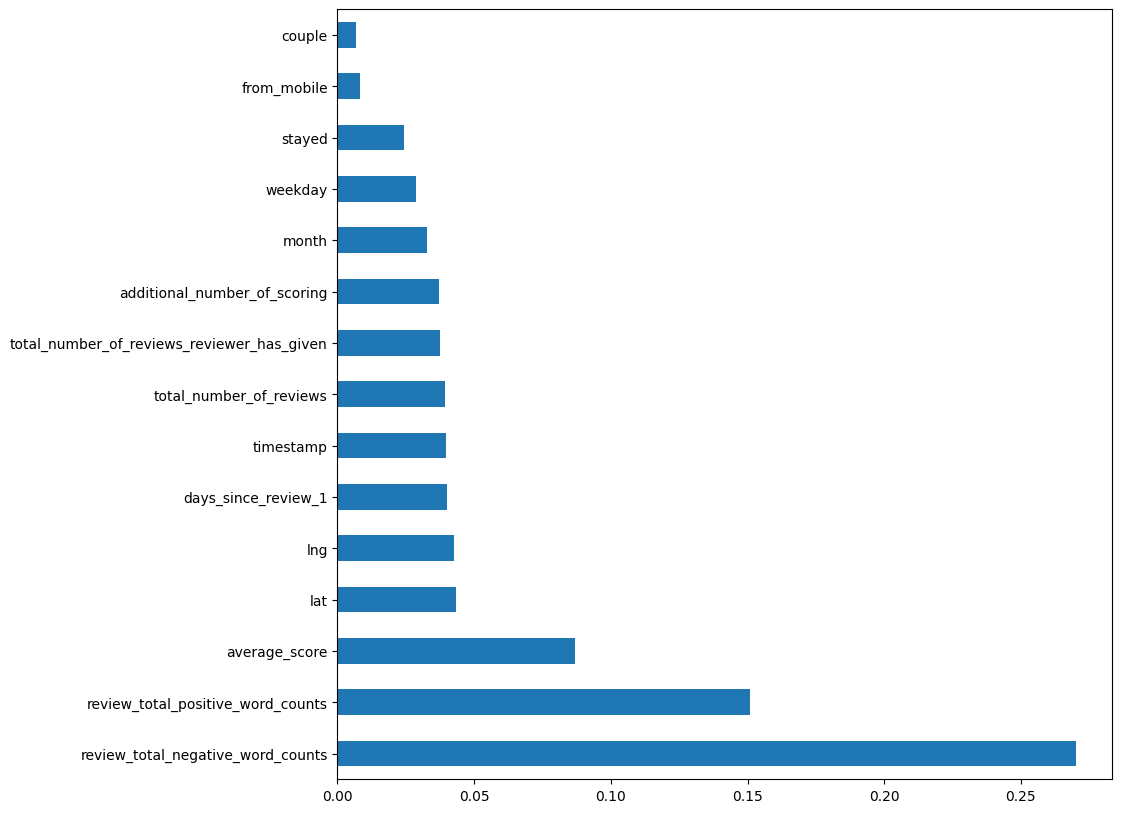

In [135]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [136]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,hotel_country_code,...,Standard Twin Room,Single Room,stayed,leisure_trip,business_trip,from_mobile,solo,couple,group,with_children
491016,118,8.1,3,737,3,17,0.0,48.201986,16.378993,0,...,0,0,1,0,1,0,1,0,0,0
448311,1322,8.4,15,6117,16,1,0.0,51.501400,-0.116009,5,...,0,0,1,1,0,1,0,0,1,0
433592,176,8.2,0,1969,13,43,0.0,45.476992,9.184490,2,...,0,0,3,1,0,0,0,0,1,0
453314,623,9.0,6,2750,28,11,0.0,51.510462,-0.079550,5,...,0,0,2,1,0,0,0,1,0,0
438272,228,8.5,0,2279,33,14,0.0,48.204465,16.370240,0,...,0,0,1,1,0,0,0,1,0,0
511366,55,8.3,49,560,74,1,0.0,48.877789,2.287250,1,...,0,0,2,0,0,0,1,0,0,0
388833,146,9.1,11,501,16,3,0.0,51.520171,-0.102463,5,...,0,0,2,1,0,0,1,0,0,0
389815,353,8.1,2,1411,5,10,0.0,51.517939,-0.152979,5,...,0,0,2,1,0,0,0,0,0,1
475052,61,7.4,0,334,31,9,0.0,51.518277,-0.158351,5,...,0,0,4,1,0,0,0,0,1,0
466716,487,8.8,49,1805,15,1,0.0,51.474469,-0.019428,5,...,0,0,1,0,0,0,0,1,0,0


In [149]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [150]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [151]:
predict_submission

array([8.778, 7.401, 8.086, ..., 8.159, 9.556, 7.281])

In [152]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.778,488440
1,7.401,274649
2,8.086,374688
3,9.598,404352
4,9.524,451596
5,7.915,302161
6,8.001,317079
7,7.302,13963
8,8.869,159785
9,8.257,195089
